- 인공 지능의 창작 활동
- 2015년 구글의 딥드림 알고리즘 : 이미지를 인공물이 뒤섞인 몽환적인 그림으로 바꿈
- 2016년 프리즈마(Prizma) 애플리케이션 : 사진을 다양한 스타일의 그림으로 바꿈
- 2016년 단편 영화 <**썬스프링**(Sunspring)> : LSTM 알고리즘이 쓴 대화가 포함된 각본을 사용하여 만듦
- 예술에서의 AI는 **확장된 지능**(augmented intelligence)으로 사람의 능력을 증가시키는 도구로 사용될 것
- 머신 러닝 모델은 이미지, 음악, 글의 통계적 **잠재 공간**(latent space)을 학습할 수 있음

# 8.1 LSTM으로 텍스트 생성하기
- 텍스트 생성 뿐만 아니라 어떤 종류의 시퀀스 데이터도 생성할 수 있음(음표 시퀀스로 새로운 음악 제작/연속된 붓질 시퀀스로 새로운 그림 그리기)
- 음성 합성과 챗봇의 대화 기능도 가능(2016년 구글의 스마트 답장(Smart Reply))

## 8.1.1 생성 RNN의 간단한 역사
- 1997년 LSTM 알고리즘 개발, 2016년부터 주류로써 사용
- 2002년 더글라스 에크(Douglas Eck)는 스위스의 슈미드후버(Schmidhuber)의 연구실에서 LSTM을 음악 생성에 처음 적용
- 2013년 알렉스 그레이브스(Alex Graves)가 펜 위치를 기록한 시계열 데이터를 사용하여 사람이 쓴 것 같은 손글씨 생성
- 이후 음악 생성, 대화 생성, 이미지 생성, 음성 합성, 분자 설계(molecule design) 등에 순환 신경망이 성공적으로 사용됨

## 8.1.2 시퀀스 데이터를 어떻게 생성할까?
- 일반적인 방법은 이전 토큰을 입력으로 사용해서 시퀀스의 다음 1개 또는 몇 개의 토큰을 (RNN이나 컨브넷으로) 예측하는 것
- **언어 모델**(language model) : 이전 토큰들이 주어졌을 때 다음 토큰의 확률을 모델링할 수 있는 네트워크
    - 언어 모델 훈련 후 샘플링(새로운 시퀀스 생성)
    - 초기 텍스트 문자열 주입(**조건 데이터**(conditioning data)), 새로운 글자나 단어 생성
    - 생성된 출력을 다시 입력 데이터로 주입
- **글자 수준의 신경망 언어 모델**(character-level neural language model) : 텍스트 말뭉치(corpus)에서 N개의 글자로 이루어진 문자열을 추출하여 주입하고 N+1번째 글자를 예측하도록 훈련

## 8.1.3 샘플링 전략의 중요성
- **탐욕적 샘플링**(greedy sampling) : 항상 가장 높은 확률을 가진 글자를 선택
    - 반복적이고 예상 가능한 문자열을 만들기 때문에 논리적인 언어로 보이지 않음
- **확률적 샘플링**(stochastic sampling) : 다음 글자의 확률 분포에서 샘플링하는 과정에 무작위성을 주입하는 방법
    - e의 확률이 0.3이라면 30%는 e를 뽑고 70%는 다른 글자를 뽑음
    - 샘플링 과정에서 무작위성의 양을 조절할 방법이 없다는 것이 문제점
- 무작위성
    - 균등 확률인 경우 최대 엔트로피를 가지며 탐욕적 샘플링의 경우 최소의 엔트로피를 가짐
    - 작은 엔트로피는 예상 가능한 구조를 가진 시퀀스 생성
    - 높은 엔트로피는 창의적인 시퀀스를 생성(주관적이기 때문에 무작위성의 양을 바꿔가며 시도해보아야 함)
- **소프트맥스 온도**(softmax temperature) 파라미터 : 샘플링에 사용되는 확률 분포의 엔트로피로, 샘플링 과정에서 확률의 양을 조절하기 위해 사용

### 다른 온도 값을 사용하여 확률 분포의 가중치 바꾸기
- 1보다 작은 실수 배열을 로그 스케일로 바꾸어 모두 음수로 만듦
- `temperature`가 1보다 작으면 더 큰 음수가 되므로 원본 스케일로 복원했을 때 배열 원소 간의 차이가 더 커짐
- 1보다 클수록 0에 가까워지고 원본 스케일로 복원했을 때 배열 원소가 비슷한 값이 됨

In [1]:
import numpy as np

def reweight_distribution(original_distribution, temperature=0.5):
    '''
    original_distribution : 전체 합이 1인 1D 넘파이 배열
    temperature : 출력 분포의 엔트로피 양을 결정
    '''
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution) # 원본 분포의 가중치를 변경하며 반환, 합이 1이 되게 함

In [2]:
distribution = np.random.random((10))
distribution = distribution / np.sum(distribution)
distribution

array([0.10826628, 0.07957782, 0.12616879, 0.08147897, 0.07377069,
       0.08234826, 0.05312677, 0.15933328, 0.08665724, 0.14927191])

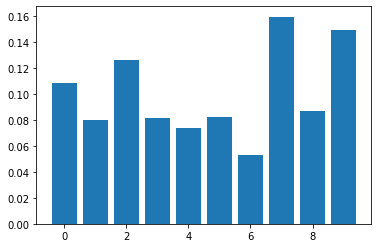

In [3]:
import matplotlib.pyplot as plt

plt.bar(np.arange(0, 10), distribution)
plt.show()

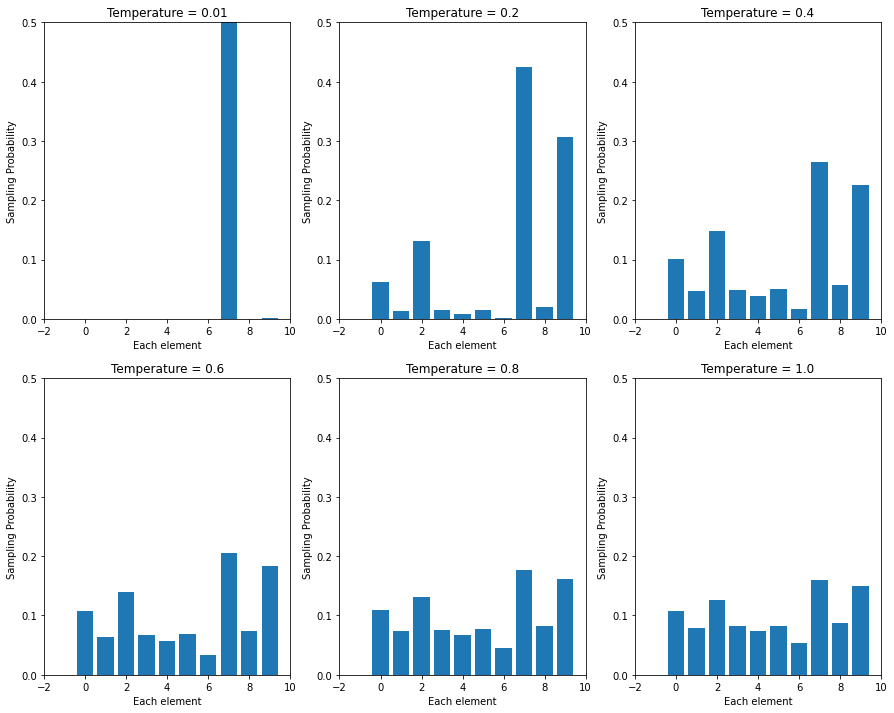

In [4]:
temps = [0.01, 0.2, 0.4, 0.6, 0.8, 1.0]

i = 1
plt.figure(figsize=(15, 12))
for temp in temps:
    re_distribution = reweight_distribution(distribution, temp)
    plt.subplot(2, 3, i)
    plt.bar(np.arange(0, 10), re_distribution)
    plt.title(f'Temperature = {temp}')
    plt.xlabel('Each element')
    plt.ylabel('Sampling Probability')
    plt.ylim((0, 0.5))
    plt.xlim((-2, 10))
    i += 1
plt.show()

- `temperature=1.0`일 때 : 원본 확률 분포
- `temperature` 값이 낮아지면 다른 확률은 거의 0에 가까워져 탐욕적 샘플링이 됨

## 8.1.4 글자 수준의 LSTM 텍스트 생성 모델 구현
- 많은 텍스트 데이터가 필요
- 니체의 글을 사용(영어로 번역)
    - 일반적인 영어 모델이 아닌 니체의 문체와 특정 주제를 따르는 모델

### 데이터 전처리
- 말뭉치를 다운받아 소문자로 바꿈

In [5]:
import tensorflow as tf
import numpy as np

path = tf.keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')

text = open(path).read().lower()
print('말뭉치 크기:', len(text))

614400/600901 [==============================] - 1s 1us/step
말뭉치 크기: 600893


### 글자 시퀀스 벡터화하기
- `maxlen` 길이를 가진 시퀀스를 중복하여 추출
- 추출된 시퀀스를 원-핫 인코딩으로 변환

In [6]:
maxlen = 60 # 60개의 글자로 된 시퀀스를 추출
step = 3 # 세 글자씩 건너뛰면서 새로운 시퀀스를 샘플링

sentences = [] # 추출한 시퀀스를 담을 리스트
next_chars = [] # 타깃(시퀀스 다음 글자)을 담을 리스트

for i in range(0, len(text)-maxlen, step):
    sentences.append(text[i:i+maxlen])
    next_chars.append(text[i+maxlen])
print('시퀀스 개수:', len(sentences))

chars = sorted(list(set(text))) # 말뭉치에서 고유한 글자를 담은 리스트
print('고유한 글자:', len(chars))
char_indices = dict((char, chars.index(char)) for char in chars) # chars 리스트에 있는 글자와 글자의 인덱스를 매핑한 딕셔너리

print('벡터화... ')
# 글자를 원-핫 인코딩하여 0과 1의 이진 열로 바꿈
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

시퀀스 개수: 200278
고유한 글자: 57
벡터화... 


### 네트워크 구성
- `LSTM` 층과 그 뒤에 `Dense` 분류기 사용(1D 컨브넷을 사용해도 됨)

In [7]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

### 모델 컴파일 설정하기

In [8]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

### 언어 모델 훈련과 샘플링
1. 지금까지 생성된 텍스트를 주입하여 모델에서 다음 글자에 대한 확률 분포를 뽑음
2. 특정 온도로 이 확률 분포의 가중치를 조정
3. 가중치가 조정된 분포에서 무작위로 새로운 글자를 샘플링
4. 새로운 글자를 생성된 텍스트의 끝에 추가

### 모델의 예측이 주어졌을 때 새로운 글자를 샘플링하는 함수
- `multinomial(n, p, s)` : `n`은 샘플링 횟수, `p`는 확률 분포 배열로 전체 합이 1이 되어야 함, `s`는 샘플링 과정을 반복할 횟수
    - `n`이 충분히 크면 반환되는 배열의 분포는 `p`의 분포에 가까워짐

In [9]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### 텍스트 생성 루프

In [10]:
%%time

import random
import sys

random.seed(42)
start_index = random.randint(0, len(text)-maxlen-1)

seed_text = text[start_index:start_index+maxlen] # 무작위로 시드 텍스트 선택
print('--- 시드 텍스트 : "' + seed_text + '"')

# 60 에포크 동안 모델 훈련, 20회마다 한 번씩 결과 출력
for epoch in range(3):
    print('에포크', epoch)
    model.fit(x, y, batch_size=128, epochs=20)
        
    # 여러 가지 샘플링 온도 시도
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ 온도:', temperature)
        generated_text = seed_text
        sys.stdout.write(generated_text)
        
        # 시드 텍스트에서 시작해서 400개의 글자를 생성
        for i in range(400):
            # 지금까지 생성된 글자를 원-핫 인코딩으로 바꿈
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
                
            # 다음 글자 샘플링
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            
            generated_text += next_char
            generated_text = generated_text[1:]
            
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

--- 시드 텍스트 : "the slowly ascending ranks and classes, in which,
through fo"
에포크 0
Epoch 1/20
1565/1565 [==============================] - 31s 16ms/step - loss: 1.9685
Epoch 2/20
1565/1565 [==============================] - 24s 16ms/step - loss: 1.6160
Epoch 3/20
1565/1565 [==============================] - 24s 16ms/step - loss: 1.5283
Epoch 4/20
1565/1565 [==============================] - 24s 16ms/step - loss: 1.4810
Epoch 5/20
1565/1565 [==============================] - 25s 16ms/step - loss: 1.4523
Epoch 6/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.4273
Epoch 7/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.4098
Epoch 8/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.3947
Epoch 9/20
1565/1565 [==============================] - 25s 16ms/step - loss: 1.3846
Epoch 10/20
1565/1565 [==============================] - 24s 16ms/step - loss: 1.3744
Epoch 11/20
1565/1565 [==============================] - 24s 15ms/s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


 from the dor-"innew,
mi_ze; formelyly" who ersage, enmity to
be is illof, with very boorp same wing
fuse gabinter cortumave" that one thing, we cher uncertain more
self-churpingrary, for founder, hur ope that they wejely for let aniacity says, no art happiness to got call
worrood
and with each mightsur t
에포크 2
Epoch 1/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.2680
Epoch 2/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.2671
Epoch 3/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.2660
Epoch 4/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.2640
Epoch 5/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.2647
Epoch 6/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.2606
Epoch 7/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.2604
Epoch 8/20
1565/1565 [==============================] - 24s 15ms/step - loss: 1.2608
Epoch 9

- 낮은 온도는 반복적이고 예상되는 텍스트를 만듦
- 높은 온도는 알 수 없는 새로운 단어를 만들어냄
- 더 많은 데이터에서 크고 깊은 모델을 훈련하면 훨씬 논리적이고 실제와 같은 텍스트 샘플을 생성할 수 있음